In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/2715746315.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/3463034205.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/268704620.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/2673564214.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/7535037918.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/4912369161.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/4828071602.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/6802728196.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/3346289227.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/3217056901.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/272471327.jpg
/kaggle/input/

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
df0 = pd.read_csv('/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv',on_bad_lines='skip')

In [4]:
print(df0.shape)
df0.head()

(141851, 1)


image_name| comment_number| comment
0  1000092795.jpg| 0| Two young guys with shaggy ...
1  1000092795.jpg| 2| Two men in green shirts are...
2  1000092795.jpg| 3| A man in a blue shirt stand...
3  1000092795.jpg| 4| Two friends enjoy time spen...
4  10002456.jpg| 0| Several men in hard hats are ...

In [5]:
df0['image_name'] = df0['image_name| comment_number| comment'].apply(lambda x: x.split('|')[0])
df0['comment_number'] = df0['image_name| comment_number| comment'].apply(lambda x: x.split('|')[1])
df0['comment'] = df0['image_name| comment_number| comment'].apply(lambda x: x.split('|')[-1])
df0.drop(['image_name| comment_number| comment'],axis = 1,inplace = True)
print(df0.shape)
df0.head(5)

(141851, 3)


image_name comment_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              2   
2  1000092795.jpg              3   
3  1000092795.jpg              4   
4    10002456.jpg              0   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two men in green shirts are standing in a yard .  
2       A man in a blue shirt standing in a garden .  
3            Two friends enjoy time spent together .  
4   Several men in hard hats are operating a gian...

In [6]:
import gc
df = df0[:50000].copy()
del df0
gc.collect()
print(df.shape)

(50000, 3)


In [7]:
def text_preprocessing(df):
    df['comment'] = df['comment'].apply(lambda x: x.lower())
    df['comment'] = df['comment'].apply(lambda x: x.replace('^a-zA-Z',''))
    df['comment'] = df['comment'].apply(lambda x: x.replace('\s+',' '))
    df['comment'] = df['comment'].apply(lambda x: ' '.join([word for word in x.split(' ') if len(word)>1]))
    df['comment'] = 'startseq' + ' ' + df['comment'] + ' ' + 'endseq'
    return df
df = text_preprocessing(df)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
captions = df['comment'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
max_length = max(len(caption.split()) for caption in captions)
num_word = len(tokenizer.word_index) + 1
print(max_length)
print(num_word)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


64
10984


In [9]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import Model
basemodel = DenseNet201()
model = Model(inputs = basemodel.input, outputs = basemodel.layers[-2].output)

82524592/82524592 [==============================] - 1s 0us/step


In [10]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm
images = df['image_name'].unique().tolist()
features = {}
for image in tqdm(images):
    img = load_img(f'/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/{image}',target_size = (224,224))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img,0)
    features[image] = model.predict(img,verbose = 0)

100%|██████████| 11033/11033 [18:12<00:00, 10.09it/s]


In [11]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import add

input1 = Input(shape = (1920,))
input2 = Input(shape = (max_length,))

img_feature = Dense(256, activation = 'relu')(input1)
img_feature_reshape = Reshape((1,256),input_shape=(256,))(img_feature)

seq_feature = Embedding(num_word, 256, mask_zero=False)(input2)
img = concatenate([img_feature_reshape,seq_feature],axis = 1)
img = LSTM(256)(img)
img = Dropout(0.5)(img)
img = add([img,img_feature])
img = Dense(512,activation = 'relu')(img)
img = Dropout(0.5)(img)
img = Dense(num_word,activation = 'softmax')(img)
model_caption = Model(inputs = [input1,input2], outputs = img)
model_caption.compile(loss = 'categorical_crossentropy',optimizer = 'adam')

In [12]:
x = round(len(images) * 0.9)
image_train = images[:x]
image_valid = images[x:]
train_data = df[df['image_name'].isin(image_train)]
valid_data = df[df['image_name'].isin(image_valid)]

In [13]:
from tensorflow.keras.utils import Sequence
class CustomDataGenerator(Sequence):
    def __init__(self, df, features, batch_size, tokenizer, max_length, num_word):
        self.df = df.copy()
        self.features = features
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.num_word = num_word
    def __len__(self):
        return self.df.shape[0]//self.batch_size
    def __getitem__(self,index):
        batch = df.iloc[self.batch_size*index:self.batch_size*(index+1),:]
        x1, x2, y = self.__get_data(batch)
        return (x1, x2), y
    def __get_data(self,batch):
        images_batch = batch.image_name.tolist()
        x1 = list()
        x2 = list()
        y = list()
        for image in images_batch:
            img_feature = self.features[image][0]
            captions = batch[batch.image_name == image].comment.tolist()
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(len(seq)):
                    a1, a2 = seq[:i],seq[i]
                    a1 = pad_sequences([a1],maxlen = self.max_length)[0]
                    a2 = to_categorical([a2],num_classes = self.num_word)[0]
                    x1.append(img_feature)
                    x2.append(a1)
                    y.append(a2)
        x1, x2, y = np.array(x1), np.array(x2), np.array(y)
        #x1 = np.expand_dims(x1,1)
        #x2 = np.expand_dims(x2,1)
        #y = np.expand_dims(y,1)
        return x1,x2,y

In [14]:
train = CustomDataGenerator(train_data,features,64,tokenizer,max_length,num_word)
valid = CustomDataGenerator(valid_data,features,64,tokenizer,max_length,num_word)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

filename = 'model.h5'
modelcheckpoint = ModelCheckpoint('model.h5',save_best_only = True)
callback = EarlyStopping()
reducelr = ReduceLROnPlateau(factor = 0.1, min_lr = 0.0000001)

In [16]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [17]:
model_caption.fit(train, epochs = 5, validation_data = valid,
                 callbacks = [modelcheckpoint,callback,reducelr]
                 )

Epoch 1/5
702/702 [==============================] - 353s 502ms/step - loss: 4.6039 - val_loss: 3.7643 - lr: 0.0010
Epoch 2/5
702/702 [==============================] - 354s 503ms/step - loss: 3.7559 - val_loss: 3.3635 - lr: 0.0010
Epoch 3/5
702/702 [==============================] - 357s 508ms/step - loss: 3.4567 - val_loss: 3.0894 - lr: 0.0010
Epoch 4/5
702/702 [==============================] - 355s 505ms/step - loss: 3.2505 - val_loss: 2.8772 - lr: 0.0010
Epoch 5/5
702/702 [==============================] - 355s 505ms/step - loss: 3.0888 - val_loss: 2.6938 - lr: 0.0010


In [18]:
def index_to_word(tokenizer, index):
    for word, ind in tokenizer.word_index.items():
        if ind == index:
            return word
    return None

In [19]:
import matplotlib.pyplot as plt
def prediction(path):
    img = load_img(path,target_size = (224,224))
    img = img_to_array(img)
    img = img/255
    img_ = np.expand_dims(img,0)
    img_feature = model.predict(img_)
    cap = 'startseq'
    for i in range(1,max_length):
        seq_feature = tokenizer.texts_to_sequences([cap])
        seq_feature = pad_sequences(seq_feature, maxlen = max_length)
        if i == 1:
            img_feature_numpy = np.array(img_feature)
            seq_feature_numpy = np.array(seq_feature)
            print(img_feature_numpy.shape)
            print(seq_feature_numpy.shape)
        inds = model_caption.predict((img_feature, seq_feature),verbose = 0)
        ind = np.argmax(inds)
        word = index_to_word(tokenizer,ind)
        if word == None:
            break
        if word == 'endseq':
            cap = cap + ' ' + word
            break
        cap = cap + ' ' + word
    plt.imshow(img)
    plt.title(cap)

1/1 [==============================] - 0s 473ms/step
(1, 1920)
(1, 64)
startseq man in blue shirt is standing in front of tree endseq


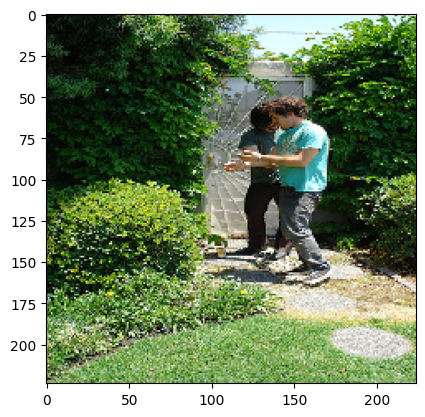

In [20]:
prediction('/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg')